In [1]:
import urllib , xmltodict , time 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from matplotlib import animation
import pandas_datareader.data as web
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

In [4]:

path_to_csv = '/home/vlad/data/treasure_yields.csv'

def _get_data(mode='new'):

    if mode =='local':
        print('Loading data from local ...')
        df = pd.read_csv(path_to_csv,index_col=0)
        df.index = pd.to_datetime(df.index)
    else:
        if mode=='new':
            url = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=month(NEW_DATE)%20eq%203%20and%20year(NEW_DATE)%20eq%202019'
        elif mode == 'all':
            url = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData'
        else:
            raise("wrong mode parameter")
        file = urllib.request.urlopen(url)
        data = file.read()
        file.close()
        f = xmltodict.parse(data)
        dd = {}
        for i in range(len(f['feed']['entry'])):
            slice_ = f['feed']['entry'][i]['content']['m:properties']
            keys = list(slice_.keys())
            try:
                date = slice_['d:NEW_DATE']['#text']
            except KeyError:
                data = None
            values_ = []
            for key in keys[2:]:
                try:
                    value = slice_[key]['#text']
                except KeyError:
                    value = None
                values_.append(value)
            dd[date] = values_

        df = pd.DataFrame.from_dict(dd,orient='index')
        df.columns = [key.split('d:')[1] for key in keys[2:]]
        print('saving to csv ...')
        df.reset_index().to_csv(path_to_csv)
    return df

_get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

In [5]:
today = dt.datetime.today().strftime('%Y-%m-%d')
start = '1995-01-01'
end = today#'2019-03-28'



tres_init = _get_data(mode='local')
snp500 = _get_px('SPY')
snp500.name = 'snp500'

tresdf = tres_init[['BC_3MONTH','BC_5YEAR','BC_10YEAR']].astype(float)
#tresdf.index = [x.split('T')[0] for x in tresdf.index]
print('DF retrieved : ',tresdf.shape)
tresdf.head()

Loading data from local ...
DF retrieved :  (7317, 3)


,BC_3MONTH,BC_5YEAR,BC_10YEAR
1997-01-02,5.19,6.30,6.54
1996-12-31,5.21,6.21,6.43
1997-01-03,5.17,6.28,6.52
1997-01-07,5.16,6.32,6.57
1997-01-06,5.17,6.30,6.54


In [46]:
#polinomial fitting

def _fit_poly(tresdf):
    x = np.array([-2.0,0.0,2.0])
    xp = np.linspace(-3, 3, 100)
    curve_params = pd.DataFrame()

    curve_data = pd.DataFrame(index=xp)
    print('Solving polynomials ...')
    time.sleep(1)
    for i in tqdm(range(len(tresdf))):
        try:
            y = np.array(tresdf.iloc[i])
            z = np.polyfit(x, y, 3)
            p = np.poly1d(z)
            px = p(xp)
            #_ = plt.plot(x, y, '.', xp, p(xp), '-')
            #time.sleep(2)
            #plt.ylim(-3,3)
        except:
            z = np.repeat(None,4)
            px = np.repeat(None,100)
        curve_data[tresdf.index[i].strftime('%Y-%m-%d')] = px
        curve_params = curve_params.append(pd.Series(z,index=['pow3','pow2','pow1','c'],name=tresdf.index[i])
                                              # ,ignore_index=True
                                              )
    curve_params.index = pd.to_datetime(curve_params.index)
    curve_params = curve_params.dropna()
    curve_data = curve_data.dropna(axis=1)
    return curve_params , curve_data

def plot_multi(data, cols=None,title='', spacing=.1,loc='upper center', **kwargs):

    from pandas import plotting
    plt.figure()
    plt.title(title)
    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_style'), '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_xlabel("Days")
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=loc
              #, bbox_to_anchor=(1, 0.5)
             )
    return ax



In [47]:

curve_params , curve_data = _fit_poly(tresdf.iloc[-(365)*12:]
                                     )
#curve_params.head()

Solving polynomials ...


100%|██████████| 4380/4380 [00:14<00:00, 254.26it/s]


In [72]:
 tresdf['5y3m_spread'] = tresdf['BC_5YEAR'] - tresdf['BC_3MONTH'] 

curve_data_t = curve_data.T.reset_index(drop=True)

poly_coef = curve_params.drop(columns=['c'])
poly_coef = poly_coef * 1e2
poly_coef_vs_snp500 = poly_coef.join(snp500,how='inner')
tresdf_vs_snp500 = tresdf.join(snp500,how='inner')

#poly_coef_vs_snp500['coef_multy'] = poly_coef_vs_snp500
poly_coef_vs_snp500['coef2'] = np.log(np.exp(np.abs(np.exp(poly_coef_vs_snp500.pow3.diff()))) *100)

<IPython.core.display.Javascript object>


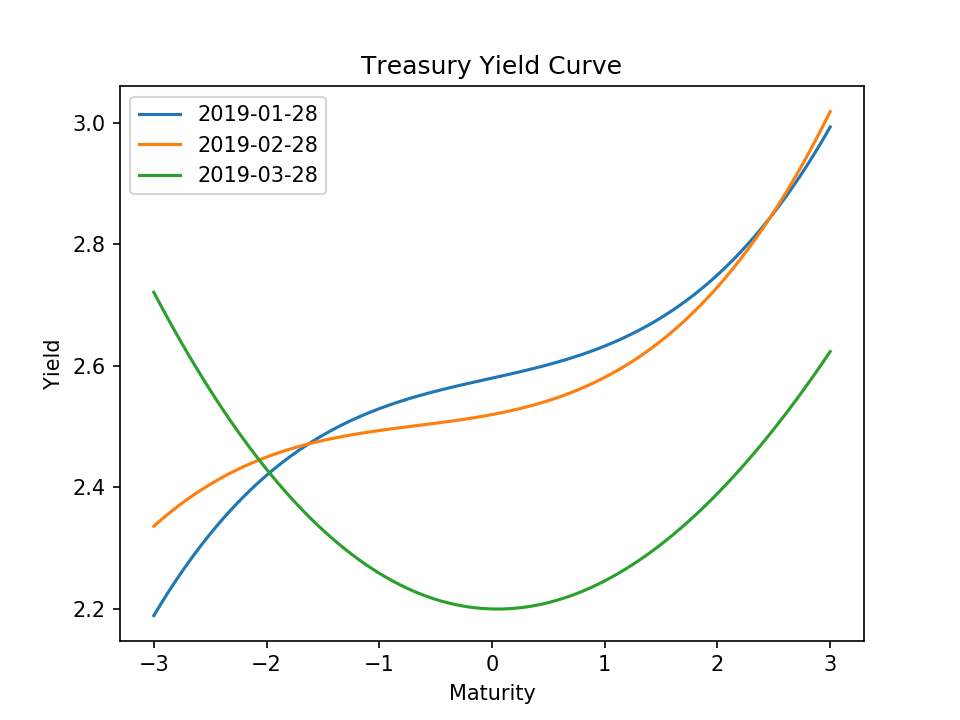

Text(0,0.5,'Yield')

In [14]:
#fig = plt.figure()

ax = curve_data[['2019-01-28','2019-02-28',today]].plot(title='Treasury Yield Curve')
ax.set_xlabel("Maturity")
ax.set_ylabel('Yield')

<IPython.core.display.Javascript object>


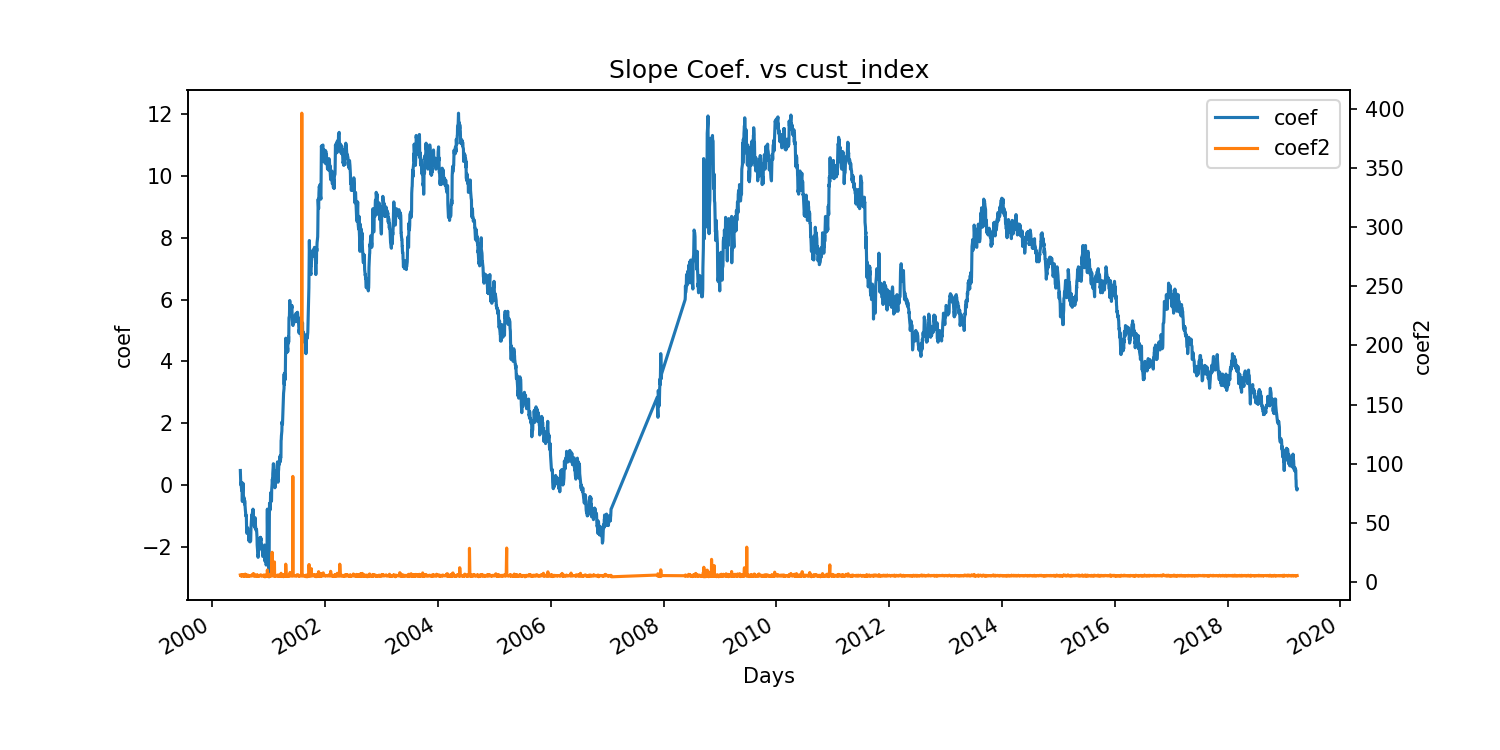

In [43]:
plot_multi(poly_coef_vs_snp500[['coef','coef2']],title='Slope Coef. vs cust_index',loc='center r', figsize=(10, 5))

<IPython.core.display.Javascript object>


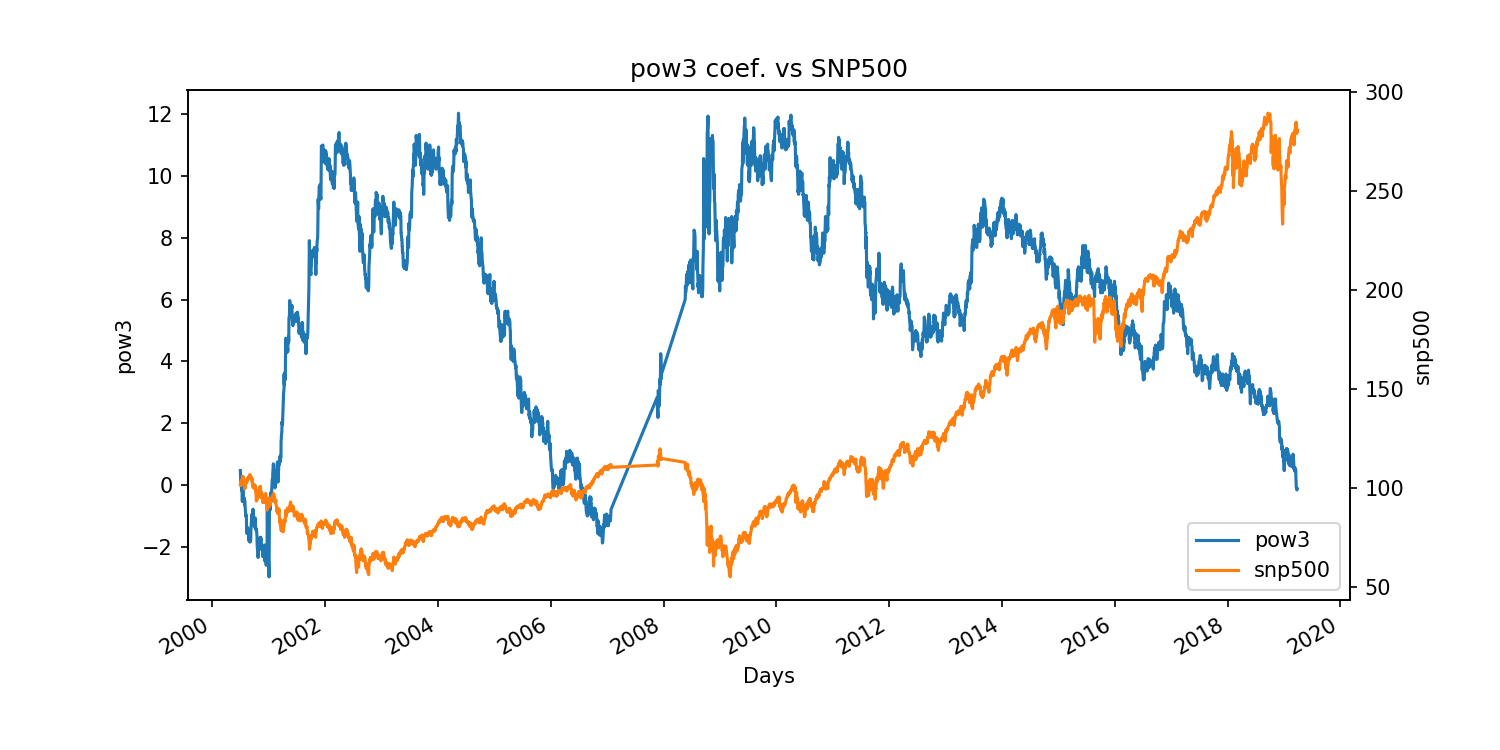

In [64]:
plot_multi(poly_coef_vs_snp500[['pow3','snp500']],title='pow3 coef. vs SNP500',loc='lower right', figsize=(10, 5))

<IPython.core.display.Javascript object>


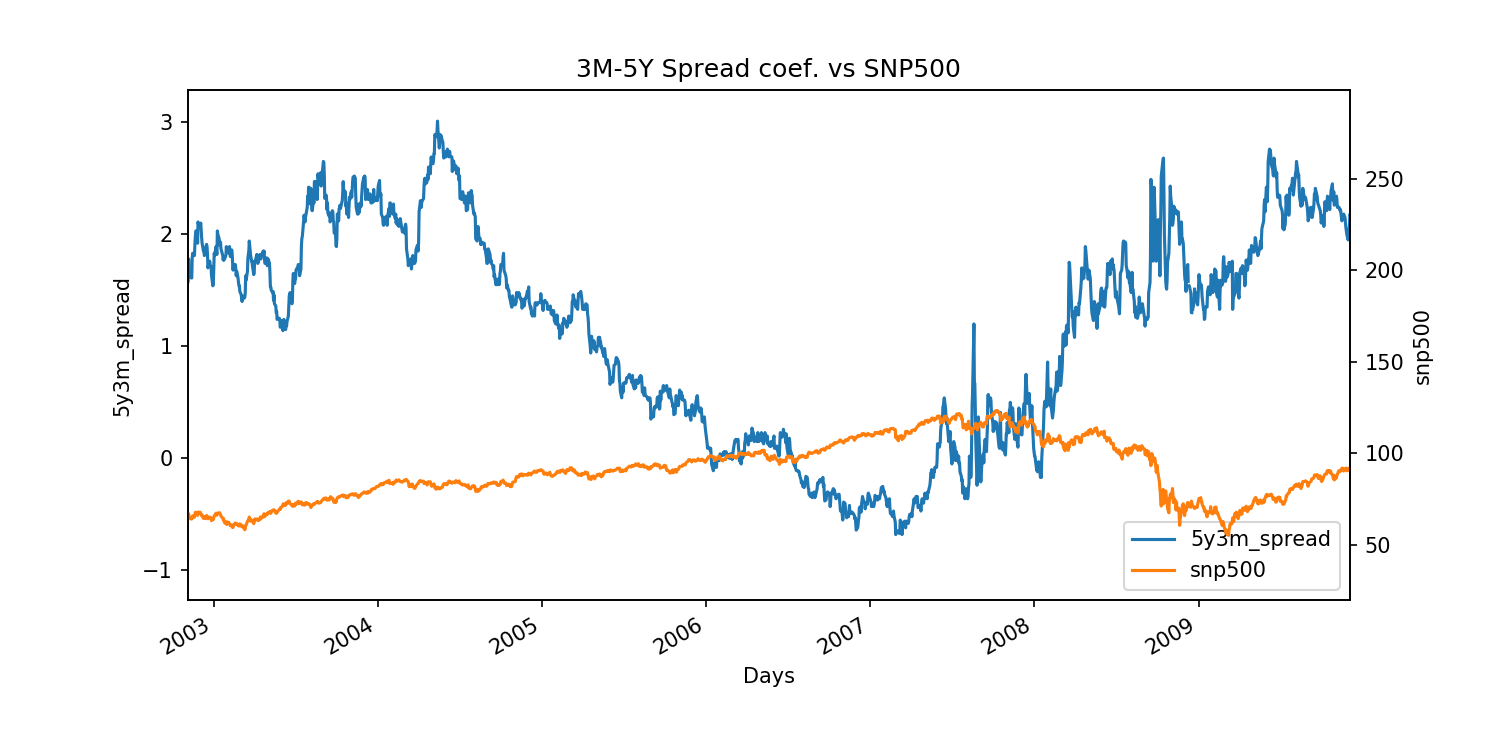

In [74]:
plot_multi(tresdf_vs_snp500[['5y3m_spread','snp500']],title='3M-5Y Spread coef. vs SNP500',loc='lower right', figsize=(10, 5))

<IPython.core.display.Javascript object>


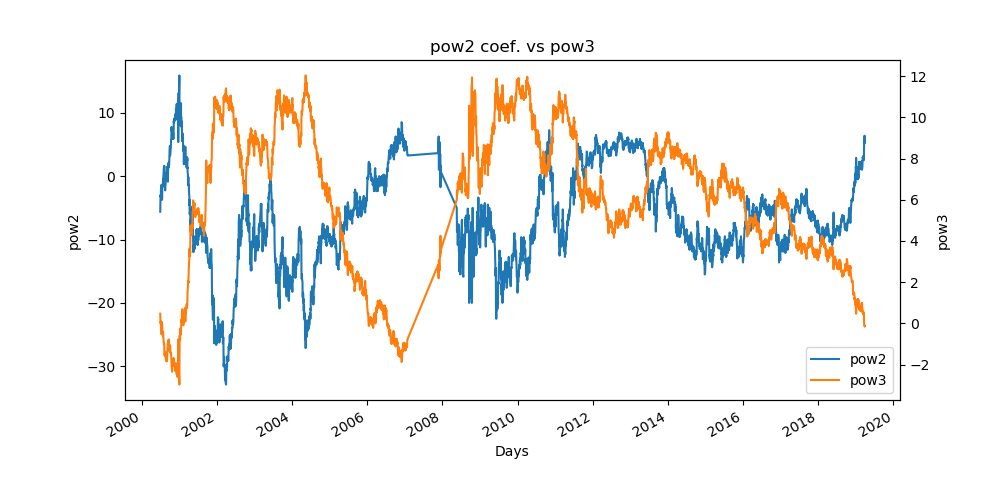

In [66]:
plot_multi(poly_coef_vs_snp500[['pow2','pow3']],title='pow2 coef. vs pow3',loc='lower right', figsize=(10, 5))

<IPython.core.display.Javascript object>


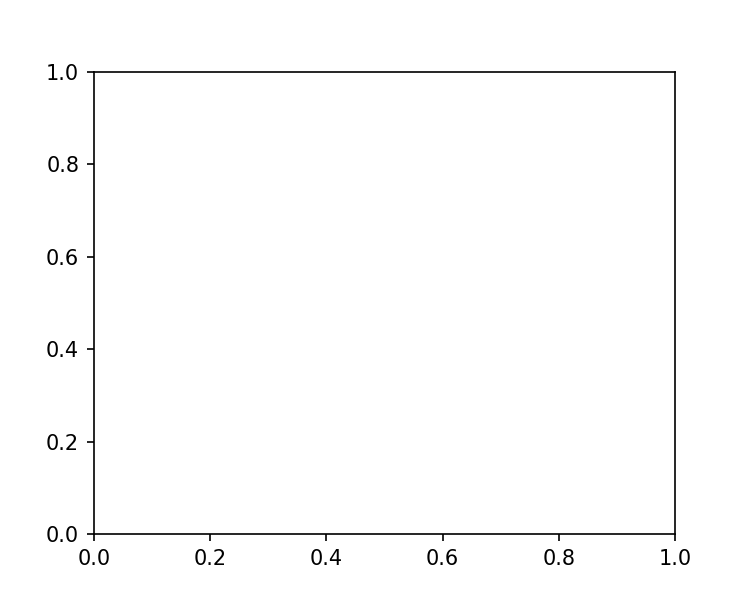

In [45]:
def animate(n,nframe):
      plt.cla()
      
      plt.plot(x, tresdf.iloc[n], '.', curve_data_t.columns.values, curve_data_t.ix[n], '-')
      plt.ylim(2.0,3)
      plt.xlim(-3,4)
      plt.text(2.4, 2.25, 'x=-2 - 3mo\nx=0 - 5y\nx=2 - 10y')
      plt.xlabel('Maturity')
      plt.ylabel('Yield')
      plt.title('Date:'+sldf.iloc[n].name+'\nShape coef.: '+str(poly_param.iloc[n,4])
               )
      font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
fig = plt.figure(figsize=(5,4))  

anim = animation.FuncAnimation(fig, animate
                             #  , frames=22
                               ,fargs=())